In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import MDS
from numpy import linalg as LA
import matplotlib.pyplot as plt

def W1_distance(U,V):
    return np.trapz(np.abs(U-V))

def Compute_Wmatrix(adata):
    batch_size_features= adata.X.shape[0]
    Mw_matrix = np.zeros((batch_size_features,batch_size_features)) #w distance matrix
    for col_i in range(0,batch_size_features):
        for col_j in range(col_i,batch_size_features):
            Mw_matrix[col_i,col_j] = W1_distance(adata.X[col_i,:],adata.X[col_j,:])
    Mw_matrix= Mw_matrix+Mw_matrix.T-np.diag(np.diag(Mw_matrix))
    np.savetxt('mymethod/MW1_matrix.csv', Mw_matrix, delimiter=',')
    return Mw_matrix

def evaluate_Kmeas_clustering(adata,d_matrix,k):
    mds = MDS(n_components=k,dissimilarity='precomputed',\
          random_state=0, normalized_stress='auto')
    X_transform = mds.fit_transform(d_matrix)
    kmeans_model = KMeans(n_clusters = 4,n_init='auto')
    kmeans_model.fit(X_transform)
    adata.obs['kmeans'] = kmeans_model.labels_ 
    adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)
    #rand_index = jaccard_score(adata.obs['Cell_Type'], adata.obs['kmeans'], average=None)
    rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['kmeans'])
    return rand_index

CPU times: user 21h 18s, sys: 1d 16h 29min 29s, total: 2d 13h 29min 47s
Wall time: 7h 50min 8s


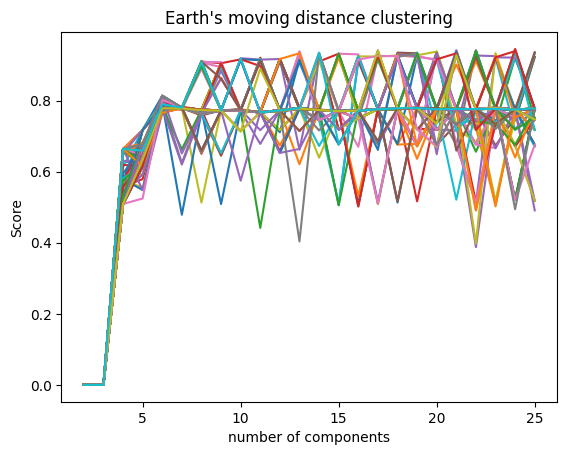

In [9]:
%%time
adata = sc.read('mymethod/cells_raw.h5ad')
sc.pp.normalize_total(adata, target_sum=1) # normalize
n_C,n_G = adata.X.shape
for cell in range(0,n_C):
    #log_u=np.log(adata.X[cell,0:-2]+1e-5)
    adata.X[cell,:]=np.log(adata.X[cell,:]+1e-3)

MW_matrix = Compute_Wmatrix(adata)
n_components=25
n_c=np.linspace(2,n_components,n_components-1)
trials=100
scores=np.zeros((trials,len(n_c)))
for t in range(0,trials):
    for k in range(2,n_components-1):
        scores[t,k]=evaluate_Kmeas_clustering(adata,MW_matrix,k)
np.savetxt('mymethod/MW_trials_scores100.csv', scores, delimiter=',')
for t in range(0,trials):
    plt.plot(n_c,scores[t,:])
plt.xlabel("number of components")
plt.ylabel("Score")
plt.title("Earth's moving distance clustering")
plt.savefig("W1_scores.svg")

CPU times: user 244 ms, sys: 263 ms, total: 507 ms
Wall time: 229 ms


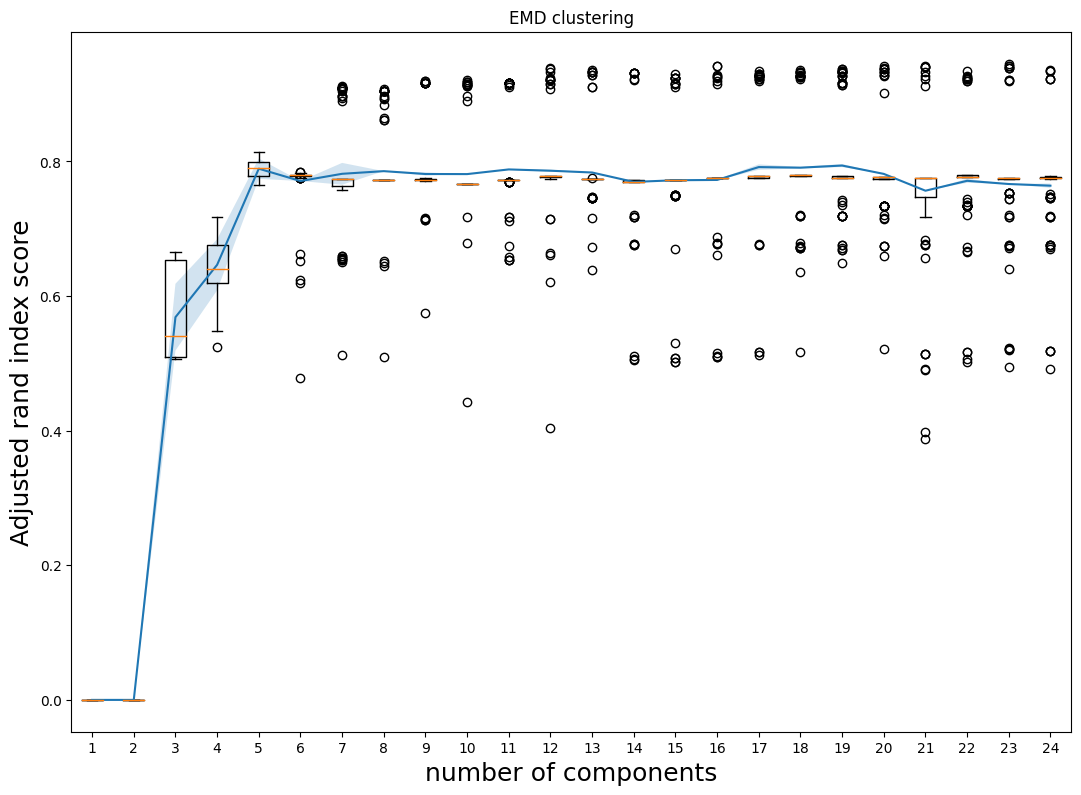

In [32]:
%%time
from statsmodels import robust
scores=np.loadtxt('mymethod/MW_trials_scores100.csv', delimiter=',')
n_components=25
mean_score=np.mean(scores,0)
mad_scores=robust.mad(scores, axis=0)
x=np.linspace(1,n_components,n_components)
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1]) 
# Creating plot

bp = ax.boxplot(scores)
plt.plot(x[0:-1],mean_score)
ax.fill_between(x[0:-1],mean_score - mad_scores, mean_score + mad_scores, alpha=0.2)
plt.xlabel("number of components", fontsize=18)
plt.ylabel("Adjusted rand index score", fontsize=18)
plt.title("EMD clustering")
plt.savefig("W1scoresstats.svg")

In [27]:
x=np.linspace(1,n_components,n_components)

In [29]:
x[0:-1]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])